**Section one**--------------------------------------------------------------------

**Feature Representation 1:** The linguistic features of the authors are represented by the pre-trained glove.6B word vectors, the input unit is a single word. 

In [231]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import nltk
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, GRU, Bidirectional, Dropout, Conv1D
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from keras.layers import MaxPooling1D, GlobalMaxPooling1D, Conv1D,Embedding,GlobalAveragePooling1D
from keras.layers import Input, Dense, AveragePooling1D
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras import optimizers, regularizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import codecs
import math
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
% matplotlib inline


#define hyperparameters as constants
MAX_TEXT_SIZE = 200
MAX_VOCABULARY_SIZE = 40000
EMBEDDING_DIM = 50

# read the file names of the input text data from csv file
dataset = pd.read_csv("data_files/data.csv", encoding = 'ISO-8859-1')
# map the author names to integers
dataset['authors'] = dataset['authors'].map({'Charles Dickens': 0, 'Mark Twain': 1, 
                                             'F. Scott Fitzgerald': 2, 'Robert Louis Stevenson': 3,
                                             'Henry James': 4, 'Ouida' : 5, 'Jack London': 6,
                                        'Joseph Conrad': 7, 'Jane Austen': 8, 'Herman Melville': 9})

#convert names to matrix
author_names = dataset['authors'].values

#read the text books (training data) and text segments (validation and tesing data) from text files
#write them in the list named 'texts'
book_files = dataset['file_name'].values
texts = []
authors = []
count_train = 0
count_val = 0

for i in range(len(book_files)):
    f = codecs.open("data_files/books/" + book_files[i], encoding='utf-8')
    text = ""
    for line in f:        
        text += str(line)
    f.close()
    #divide the book to paragraphs
    text_sentences = text.split("\r\n\r\n")
    text_sentences = [para.replace("\r\n"," ").replace('“',' ').replace('”','').replace('-',' ')
                      .replace('*', ' ').replace('\ufeff', ' ') for para in text_sentences]
    text_sentences = [para.strip() for para in text_sentences]
    short_text = []
    #combine short paragraphs to longer ones with a maximum size of 200 words.
    for t in text_sentences:
        if len(t.split(" ")) < 50:
            short_text.append(t) 
            text_sentences.remove(t)
    ii = 0
    com_text=[]
    while ii < len(short_text):
        if (len(short_text[ii].split(" ")) < 50):
            j = ii+1
            combine = short_text[ii]
            while (j < len(short_text) and len((combine+short_text[j]).split(" ")) < 200):
                combine+=short_text[j]
                j+=1
            com_text.append(combine)     
            ii = j
        else:
            i+=1
    text_sentences += com_text
 
    if i < 10:
        count_train += len(text_sentences)
    if i >= 10 and i < 20:
        count_val += len(text_sentences)
    
    texts += text_sentences
    authors += [author_names[i]]*len(text_sentences)
       
texts = np.asarray(texts)
authors = np.asarray(authors)

# convert labels to categorical input
authors = np_utils.to_categorical(authors, 10)
authors_train = authors[:count_train]
authors_val = authors[count_train : count_train + count_val]
authors_test = authors[count_train + count_val :]

In [232]:
#Tokenize the texts 
tokenizer = Tokenizer(num_words = MAX_VOCABULARY_SIZE)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

#pad the sequences
sequences = pad_sequences(sequences, maxlen = MAX_TEXT_SIZE)

sequences_train = sequences[:count_train]
sequences_val = sequences[count_train : count_train + count_val]
sequences_test = sequences[count_train + count_val :]


#generate the word-to-index array
word2idx = tokenizer.word_index

#create the word_to_feature_vectors using the pre-trained word vectors from http://nlp.standford.edu
word2vec = {}
with open("data_files/word_vector/glove.6B.%sd.txt" % EMBEDDING_DIM, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype = 'float32')
        word2vec[word] = vec        
        
#Create the embedding matrix, map the tokens to word vectors
num_words = min(MAX_VOCABULARY_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCABULARY_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector           

In [233]:
optimizer_ = optimizers.Adam(lr = 0.001)
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='auto')
#create the embedding objects and then the model
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights = [embedding_matrix],
                            input_length = MAX_TEXT_SIZE, trainable = False)


In [234]:
BATCH_SIZE = 64
EPOCHS = 100
#create models and train the models
model_GRU = Sequential()
model_GRU.add(embedding_layer)
model_GRU.add(GRU(10))
model_GRU.add(Dense(10, activation = 'softmax'))
model_GRU.compile(loss = 'categorical_crossentropy', optimizer = optimizer_, metrics = ['accuracy'])
r_GRU = model_GRU.fit(sequences_train, authors_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
             callbacks = [earlyStopping], validation_data=(sequences_val, authors_val), shuffle = True)

Train on 12560 samples, validate on 1379 samples
Epoch 1/100
12560/12560 [==============================] - 22s - loss: 2.2549 - acc: 0.1850 - val_loss: 2.2484 - val_acc: 0.1704
Epoch 2/100
12560/12560 [==============================] - 19s - loss: 2.1256 - acc: 0.2467 - val_loss: 2.0785 - val_acc: 0.2589- E
Epoch 3/100
12560/12560 [==============================] - 20s - loss: 1.9466 - acc: 0.3148 - val_loss: 1.9570 - val_acc: 0.2763
Epoch 4/100
12560/12560 [==============================] - 19s - loss: 1.8456 - acc: 0.3428 - val_loss: 1.8759 - val_acc: 0.2944
Epoch 5/100
12560/12560 [==============================] - 19s - loss: 1.7637 - acc: 0.3643 - val_loss: 1.8126 - val_acc: 0.3183
Epoch 6/100
12560/12560 [==============================] - 20s - loss: 1.6925 - acc: 0.3943 - val_loss: 1.7554 - val_acc: 0.3452
Epoch 7/100
12560/12560 [==============================] - 20s - loss: 1.6187 - acc: 0.4277 - val_loss: 1.6861 - val_acc: 0.3793: 7s - loss: 1.6292 - acc: - E
Epoch 8/100
125

12560/12560 [==============================] - 19s - loss: 0.9527 - acc: 0.6740 - val_loss: 1.2038 - val_acc: 0.6128
Epoch 64/100
12560/12560 [==============================] - 19s - loss: 0.9550 - acc: 0.6728 - val_loss: 1.2073 - val_acc: 0.6012
Epoch 65/100
12560/12560 [==============================] - 19s - loss: 0.9462 - acc: 0.6768 - val_loss: 1.2153 - val_acc: 0.5975
Epoch 66/100
12560/12560 [==============================] - 19s - loss: 0.9453 - acc: 0.6744 - val_loss: 1.1934 - val_acc: 0.6106
Epoch 67/100
12560/12560 [==============================] - 21s - loss: 0.9474 - acc: 0.6748 - val_loss: 1.2025 - val_acc: 0.6113
Epoch 68/100
12560/12560 [==============================] - 21s - loss: 0.9417 - acc: 0.6766 - val_loss: 1.1904 - val_acc: 0.6120
Epoch 69/100
12560/12560 [==============================] - 20s - loss: 0.9375 - acc: 0.6793 - val_loss: 1.2033 - val_acc: 0.6084
Epoch 70/100
12560/12560 [==============================] - 20s - loss: 0.9370 - acc: 0.6796 - val_loss

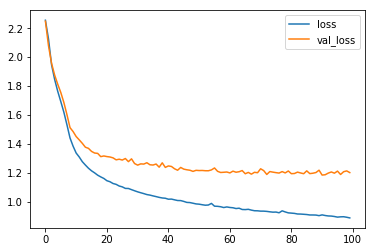

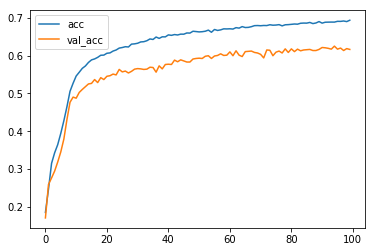

hightest acc is: 0.693630573248
hightest val_acc is: 0.625090646087
hightest val_acc epoch is: 94


In [235]:
plt.plot(r_GRU.history['loss'], label = 'loss')
plt.plot(r_GRU.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()
plt.plot(r_GRU.history['acc'], label = 'acc')
plt.plot(r_GRU.history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()
print('hightest acc is:', np.max(r_GRU.history['acc']))
print('hightest val_acc is:', np.max(r_GRU.history['val_acc']))
print('hightest val_acc epoch is:', np.argmax(r_GRU.history['val_acc']))


In [236]:
predictions_raw_GRU = [model_GRU.predict(np.expand_dims(feature, axis=0)) for feature in sequences_test]
predictions_GRU = [np.argmax(percentage) for percentage in predictions_raw_GRU] 
test_accuracy_GRU = 100*np.sum(np.array(predictions_GRU) == np.argmax(authors_test, axis=1))/len(predictions_GRU)
print('GRU Test accuracy: %.4f%%' % test_accuracy_GRU)
print('F1_GRU score is: ',f1_score(np.array(predictions_GRU), np.argmax(authors_test, axis=1),average='weighted'))

GRU Test accuracy: 64.0449%
F1_GRU score is:  0.6429424131


In [237]:
#LSTM model
model_LSTM = Sequential()
model_LSTM.add(embedding_layer)
model_LSTM.add(LSTM(10))
model_LSTM.add(Dense(10, activation = 'softmax'))
model_LSTM.compile(loss = 'categorical_crossentropy', optimizer = optimizer_, metrics = ['accuracy'])
r_LSTM = model_LSTM.fit(sequences_train, authors_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
             callbacks = [earlyStopping], validation_data=(sequences_val, authors_val), shuffle = True)

Train on 12560 samples, validate on 1379 samples
Epoch 1/100
12560/12560 [==============================] - 29s - loss: 2.0925 - acc: 0.2388 - val_loss: 2.0350 - val_acc: 0.2480
Epoch 2/100
12560/12560 [==============================] - 25s - loss: 1.8047 - acc: 0.3568 - val_loss: 1.7986 - val_acc: 0.3575
Epoch 3/100
12560/12560 [==============================] - 25s - loss: 1.6584 - acc: 0.4104 - val_loss: 1.6774 - val_acc: 0.4061
Epoch 4/100
12560/12560 [==============================] - 25s - loss: 1.5483 - acc: 0.4532 - val_loss: 1.5891 - val_acc: 0.4249
Epoch 5/100
12560/12560 [==============================] - 26s - loss: 1.4685 - acc: 0.4891 - val_loss: 1.5154 - val_acc: 0.4706
Epoch 6/100
12560/12560 [==============================] - 26s - loss: 1.4021 - acc: 0.5155 - val_loss: 1.4610 - val_acc: 0.4888
Epoch 7/100
12560/12560 [==============================] - 25s - loss: 1.3492 - acc: 0.5354 - val_loss: 1.4349 - val_acc: 0.5018
Epoch 8/100
12560/12560 [=======================

12560/12560 [==============================] - 24s - loss: 0.8739 - acc: 0.6984 - val_loss: 1.2205 - val_acc: 0.6026
Epoch 64/100
12560/12560 [==============================] - 24s - loss: 0.8714 - acc: 0.6982 - val_loss: 1.2336 - val_acc: 0.6012
Epoch 65/100
12560/12560 [==============================] - 24s - loss: 0.8698 - acc: 0.6998 - val_loss: 1.2190 - val_acc: 0.5946
Epoch 66/100
12560/12560 [==============================] - 24s - loss: 0.8667 - acc: 0.7036 - val_loss: 1.2478 - val_acc: 0.5925
Epoch 67/100
12560/12560 [==============================] - 24s - loss: 0.8657 - acc: 0.7039 - val_loss: 1.2269 - val_acc: 0.5975
Epoch 68/100
12560/12560 [==============================] - 24s - loss: 0.8642 - acc: 0.7019 - val_loss: 1.2180 - val_acc: 0.5954
Epoch 69/100
12560/12560 [==============================] - 24s - loss: 0.8614 - acc: 0.7029 - val_loss: 1.2461 - val_acc: 0.6012
Epoch 70/100
12560/12560 [==============================] - 24s - loss: 0.8614 - acc: 0.7075 - val_loss

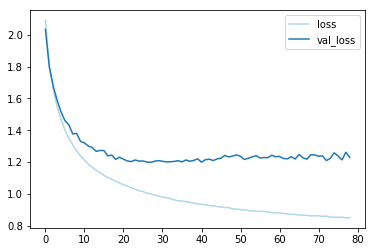

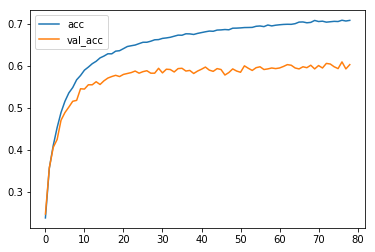

LSTM hightest acc is: 0.707961783439
LSTM hightest val_acc is: 0.609137056443
LSTM hightest val_acc epoch is: 76


In [238]:
plt.plot(r_LSTM.history['loss'], label = 'loss', color = '#ADD8E6')
plt.plot(r_LSTM.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()
plt.plot(r_LSTM.history['acc'], label = 'acc')
plt.plot(r_LSTM.history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()
#print('LSTM hightest acc is:', np.max(r_LSTM.history['acc']))
#print('LSTM hightest val_acc is:', np.max(r_LSTM.history['val_acc']))
#print('LSTM hightest val_acc epoch is:', np.argmax(r_LSTM.history['val_acc']))

In [24]:
predictions_raw_LSTM = [model_LSTM.predict(np.expand_dims(feature, axis=0)) for feature in sequences_test]
predictions_LSTM = [np.argmax(percentage) for percentage in predictions_raw_LSTM] 
test_accuracy_LSTM = 100*np.sum(np.array(predictions_LSTM) == np.argmax(authors_test, axis=1))/len(predictions_LSTM)
print('LSTM Test accuracy: %.4f%%' % test_accuracy_LSTM)
print('F1_LSTM score is: ',f1_score(np.array(predictions_LSTM), np.argmax(authors_test, axis=1),average='weighted'))

LSTM Test accuracy: 69.6629%
F1_LSTM score is:  0.702622889378


In [242]:
#CNN models
optimizer_ = optimizers.Adam(lr = 0.001)
model_CNN = Sequential()
model_CNN.add(embedding_layer)
model_CNN.add(Conv1D(128,3, activation = 'relu'))
model_CNN.add(MaxPooling1D(3))
model_CNN.add(Conv1D(128,3, activation = 'relu'))
model_CNN.add(MaxPooling1D(3))
model_CNN.add(Conv1D(128,3, activation = 'relu'))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dense(128, activation = 'relu'))
model_CNN.add(Dense(10, activation = 'softmax'))
model_CNN.compile(loss = 'categorical_crossentropy', optimizer = optimizer_, metrics = ['accuracy'])
r_CNN = model_CNN.fit(sequences_train, authors_train, batch_size = BATCH_SIZE, epochs = 10,
             callbacks = [earlyStopping], validation_data=(sequences_val, authors_val), shuffle = True)

Train on 12560 samples, validate on 1379 samples
Epoch 1/10
12560/12560 [==============================] - 26s - loss: 2.0980 - acc: 0.2367 - val_loss: 1.9522 - val_acc: 0.2734
Epoch 2/10
12560/12560 [==============================] - 23s - loss: 1.6228 - acc: 0.4024 - val_loss: 1.6355 - val_acc: 0.4003
Epoch 3/10
12560/12560 [==============================] - 24s - loss: 1.3469 - acc: 0.5111 - val_loss: 1.4215 - val_acc: 0.4917
Epoch 4/10
12560/12560 [==============================] - 25s - loss: 1.1626 - acc: 0.5839 - val_loss: 1.1894 - val_acc: 0.5838
Epoch 5/10
12560/12560 [==============================] - 23s - loss: 1.0080 - acc: 0.6388 - val_loss: 1.2464 - val_acc: 0.6062
Epoch 6/10
12560/12560 [==============================] - 23s - loss: 0.8859 - acc: 0.6810 - val_loss: 1.1636 - val_acc: 0.6055
Epoch 7/10
12560/12560 [==============================] - 23s - loss: 0.7914 - acc: 0.7139 - val_loss: 1.1140 - val_acc: 0.6650
Epoch 8/10
12560/12560 [==============================]

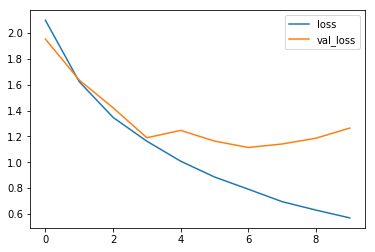

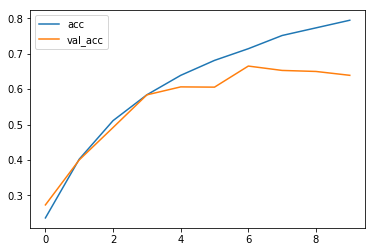

In [243]:
plt.plot(r_CNN.history['loss'], label = 'loss')
plt.plot(r_CNN.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()
plt.plot(r_CNN.history['acc'], label = 'acc')
plt.plot(r_CNN.history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()
#print('CNN hightest acc is:', np.max(r_CNN.history['acc']))
#print('CNN hightest val_acc is:', np.max(r_CNN.history['val_acc']))
#print('CNN hightest val_acc epoch is:', np.argmax(r_CNN.history['val_acc']))

In [244]:
predictions_raw_CNN = [model_CNN.predict(np.expand_dims(feature, axis=0)) for feature in sequences_test]
predictions_CNN = [np.argmax(percentage) for percentage in predictions_raw_CNN] 
test_accuracy_CNN = 100*np.sum(np.array(predictions_CNN) == np.argmax(authors_test, axis=1))/len(predictions_CNN)
print('CNN Test accuracy: %.4f%%' % test_accuracy_CNN)
print('F1_CNN score is: ',f1_score(np.array(predictions_CNN), np.argmax(authors_test, axis=1),average='weighted'))

CNN Test accuracy: 64.7940%
F1_CNN score is:  0.646479587438


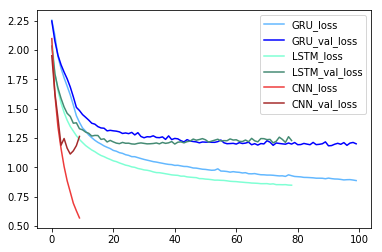

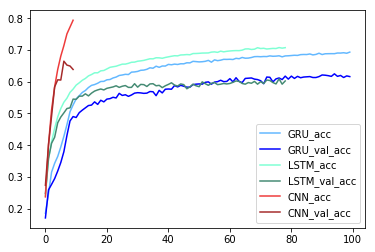

In [245]:
plt.plot(r_GRU.history['loss'], label = 'GRU_loss', color = '#63B8FF')
plt.plot(r_GRU.history['val_loss'], label = 'GRU_val_loss',color = '#0000FF')
plt.plot(r_LSTM.history['loss'], label = 'LSTM_loss', color = '#7FFFD4')
plt.plot(r_LSTM.history['val_loss'], label = 'LSTM_val_loss',color = '#458B74')
plt.plot(r_CNN.history['loss'], label = 'CNN_loss', color = '#EE3B3B')
plt.plot(r_CNN.history['val_loss'], label = 'CNN_val_loss',color = '#A52A2A')
plt.legend()
plt.show()
plt.plot(r_GRU.history['acc'], label = 'GRU_acc', color = '#63B8FF')
plt.plot(r_GRU.history['val_acc'], label = 'GRU_val_acc',color = '#0000FF')
plt.plot(r_LSTM.history['acc'], label = 'LSTM_acc', color = '#7FFFD4')
plt.plot(r_LSTM.history['val_acc'], label = 'LSTM_val_acc',color = '#458B74')
plt.plot(r_CNN.history['acc'], label = 'CNN_acc', color = '#EE3B3B')
plt.plot(r_CNN.history['val_acc'], label = 'CNN_val_acc',color = '#A52A2A')
plt.legend()
plt.show()

**Section Two**--------------------------------------------------------------------------------- 

**Feature Representation 2:** The linguistic features of the authors are represented by the pre-trained glove.6B word vectors, the input unit is a single **sentence**. 

In [246]:
import math
texts_for_token = []
authors = []
count_train = 0
count_val = 0
texts = []

for i in range(len(book_files)):
    f = codecs.open("data_files/books/" + book_files[i], encoding='utf-8')
    text = ""
    for line in f:        
        text += str(line)
    f.close()
    #divide the book to paragraphs
    text = text.replace("\r\n\r\n", ' ').replace("\r\n",' ').replace('“',' ').replace('”',' ').replace('-',' ').replace('*', ' ').replace('\ufeff', ' ')
    text_sentences = text.split(".")    
    text_sentences = [sentence.strip() for sentence in text_sentences]
    text_sentences = [sentence for sentence in text_sentences if len(sentence) > 2]
    texts_for_token += text_sentences
    
    # combine ten sentences into one paragraphs
    row = math.floor(len(text_sentences)/10)
    text_sentences = text_sentences[:row*10]
    text_paras = np.reshape(text_sentences,(row, 10))
 
   
    if i < 10:
        count_train += row
    if i >= 10 and i < 20:
        count_val += row
   
    texts += list(text_paras)
    authors += [author_names[i]]*row

print('len(texts)',len(texts))
authors = np.asarray(authors)
                     
# convert labels to categorical input
authors = np_utils.to_categorical(authors, 10)
authors_train = authors[:count_train]
authors_val = authors[count_train : count_train + count_val]
authors_test = authors[count_train + count_val :]


len(texts) 5598


In [247]:
#maximum sentence size
MAX_TEXT_SIZE = 40

#Tokenize the texts_train and generate the word-to-index array 
tokenizer = Tokenizer(num_words = MAX_VOCABULARY_SIZE)
tokenizer.fit_on_texts(texts_for_token)
seq=[]
for i in range (len(texts)):
    sequences = tokenizer.texts_to_sequences(texts[i])
    seq.append(sequences)

seq_pad=[]

#pad the sequences
for sequences in seq:
    sequence_para = pad_sequences(sequences, maxlen = MAX_TEXT_SIZE)
    seq_pad.append(sequence_para)

word2idx = tokenizer.word_index

# Create the word_to_feature_vectors using the pre-trained word vectors from http://nlp.standford.edu
word2vec = {}
with open("data_files/word_vector/glove.6B.%sd.txt" % EMBEDDING_DIM, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype = 'float32')
        word2vec[word] = vec            
        
# Create the embedding matrix, map the tokens to word vectors
num_words = min(MAX_VOCABULARY_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCABULARY_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
seq_vecs = []           
seq_vecs = [[[embedding_matrix[i] for i in sentence] for sentence in para] for para in seq_pad]

#print(len(seq_vecs))            
#print(len(seq_vecs[0]))

In [248]:
#the feature of a sentence is represented by the mean vectors of all the words in it.
seq_mean = [[np.mean(sentence, axis = 0) for sentence in para] for para in seq_vecs] 
seq_mean = np.asarray(seq_mean)
#print(np.shape(seq_mean))
#print(type(seq_mean))            
#print("np.argmax(authors_test, axis=1) :", np.argmax(authors_test, axis=1))

(5598, 10, 50)
<class 'numpy.ndarray'>


In [249]:
sequences_train = seq_mean[:count_train]
sequences_val = seq_mean[count_train : count_train + count_val]
sequences_test = seq_mean[count_train + count_val :]

In [250]:
#LSTM model
hidden_size = 2
BATCH_SIZE = 64
EPOCHS = 300
earlyStopping = EarlyStopping(monitor='val_loss', patience=60, verbose=0, mode='auto')
optimizer_ = optimizers.Adam(lr = 0.001)
model_sent_LSTM = Sequential()
#model.add(LSTM(32, return_sequences = True))
#for i in range (hidden_size):
    #model.add(LSTM(64, return_sequences = True))
model_sent_LSTM.add(LSTM(10,input_shape = (10,50)))
model_sent_LSTM.add(Dense(10, activation = 'softmax'))
model_sent_LSTM.compile(loss = 'categorical_crossentropy', optimizer = optimizer_, metrics = ['accuracy'])
r_sent_LSTM = model_sent_LSTM.fit(sequences_train, authors_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
             validation_data=(sequences_val, authors_val), shuffle = True)

Train on 4885 samples, validate on 592 samples
Epoch 1/300
4885/4885 [==============================] - 4s - loss: 2.2716 - acc: 0.1275 - val_loss: 2.2825 - val_acc: 0.1385
Epoch 2/300
4885/4885 [==============================] - 0s - loss: 2.2119 - acc: 0.1873 - val_loss: 2.1825 - val_acc: 0.2365
Epoch 3/300
4885/4885 [==============================] - 1s - loss: 2.0738 - acc: 0.2317 - val_loss: 2.0202 - val_acc: 0.2432
Epoch 4/300
4885/4885 [==============================] - 0s - loss: 1.9552 - acc: 0.2921 - val_loss: 1.9430 - val_acc: 0.3108
Epoch 5/300
4885/4885 [==============================] - 0s - loss: 1.8562 - acc: 0.3376 - val_loss: 1.8345 - val_acc: 0.3480
Epoch 6/300
4885/4885 [==============================] - 0s - loss: 1.7808 - acc: 0.3648 - val_loss: 1.7637 - val_acc: 0.3818
Epoch 7/300
4885/4885 [==============================] - 0s - loss: 1.7221 - acc: 0.3851 - val_loss: 1.7081 - val_acc: 0.3801
Epoch 8/300
4885/4885 [==============================] - 0s - loss: 1.6

4885/4885 [==============================] - 0s - loss: 0.9023 - acc: 0.6811 - val_loss: 1.1624 - val_acc: 0.5676
Epoch 66/300
4885/4885 [==============================] - 0s - loss: 0.8910 - acc: 0.6897 - val_loss: 1.1815 - val_acc: 0.5743
Epoch 67/300
4885/4885 [==============================] - 0s - loss: 0.8913 - acc: 0.6790 - val_loss: 1.1941 - val_acc: 0.5659
Epoch 68/300
4885/4885 [==============================] - 0s - loss: 0.8845 - acc: 0.6882 - val_loss: 1.1871 - val_acc: 0.5693
Epoch 69/300
4885/4885 [==============================] - 0s - loss: 0.8798 - acc: 0.6919 - val_loss: 1.1470 - val_acc: 0.5811
Epoch 70/300
4885/4885 [==============================] - 0s - loss: 0.8779 - acc: 0.6890 - val_loss: 1.1628 - val_acc: 0.5760
Epoch 71/300
4885/4885 [==============================] - 0s - loss: 0.8737 - acc: 0.6923 - val_loss: 1.1785 - val_acc: 0.5760
Epoch 72/300
4885/4885 [==============================] - 0s - loss: 0.8652 - acc: 0.6958 - val_loss: 1.1631 - val_acc: 0.57

4885/4885 [==============================] - 0s - loss: 0.7243 - acc: 0.7460 - val_loss: 1.0772 - val_acc: 0.6166
Epoch 130/300
4885/4885 [==============================] - 0s - loss: 0.7249 - acc: 0.7492 - val_loss: 1.0644 - val_acc: 0.6132
Epoch 131/300
4885/4885 [==============================] - 0s - loss: 0.7219 - acc: 0.7462 - val_loss: 1.0743 - val_acc: 0.6166
Epoch 132/300
4885/4885 [==============================] - 0s - loss: 0.7229 - acc: 0.7437 - val_loss: 1.0652 - val_acc: 0.6199
Epoch 133/300
4885/4885 [==============================] - 0s - loss: 0.7093 - acc: 0.7517 - val_loss: 1.1096 - val_acc: 0.6166
Epoch 134/300
4885/4885 [==============================] - 0s - loss: 0.7111 - acc: 0.7480 - val_loss: 1.0896 - val_acc: 0.6149
Epoch 135/300
4885/4885 [==============================] - 0s - loss: 0.7101 - acc: 0.7488 - val_loss: 1.0641 - val_acc: 0.6216
Epoch 136/300
4885/4885 [==============================] - 0s - loss: 0.7124 - acc: 0.7460 - val_loss: 1.0704 - val_ac

4885/4885 [==============================] - 0s - loss: 0.6385 - acc: 0.7724 - val_loss: 1.0631 - val_acc: 0.6368
Epoch 194/300
4885/4885 [==============================] - 0s - loss: 0.6377 - acc: 0.7803 - val_loss: 1.0852 - val_acc: 0.6301
Epoch 195/300
4885/4885 [==============================] - 0s - loss: 0.6413 - acc: 0.7734 - val_loss: 1.0591 - val_acc: 0.6334
Epoch 196/300
4885/4885 [==============================] - 0s - loss: 0.6323 - acc: 0.7810 - val_loss: 1.0803 - val_acc: 0.6368
Epoch 197/300
4885/4885 [==============================] - 0s - loss: 0.6309 - acc: 0.7781 - val_loss: 1.0609 - val_acc: 0.6385
Epoch 198/300
4885/4885 [==============================] - 0s - loss: 0.6312 - acc: 0.7769 - val_loss: 1.0345 - val_acc: 0.6419
Epoch 199/300
4885/4885 [==============================] - 0s - loss: 0.6262 - acc: 0.7846 - val_loss: 1.0937 - val_acc: 0.6351
Epoch 200/300
4885/4885 [==============================] - 0s - loss: 0.6271 - acc: 0.7797 - val_loss: 1.0935 - val_ac

4885/4885 [==============================] - 0s - loss: 0.5754 - acc: 0.8008 - val_loss: 1.0422 - val_acc: 0.6655
Epoch 258/300
4885/4885 [==============================] - 0s - loss: 0.5744 - acc: 0.7990 - val_loss: 1.0340 - val_acc: 0.6453
Epoch 259/300
4885/4885 [==============================] - 0s - loss: 0.5796 - acc: 0.7984 - val_loss: 1.0374 - val_acc: 0.6554
Epoch 260/300
4885/4885 [==============================] - 0s - loss: 0.5852 - acc: 0.7988 - val_loss: 1.0301 - val_acc: 0.6689
Epoch 261/300
4885/4885 [==============================] - 0s - loss: 0.5767 - acc: 0.7994 - val_loss: 1.0449 - val_acc: 0.6402
Epoch 262/300
4885/4885 [==============================] - 0s - loss: 0.5705 - acc: 0.8002 - val_loss: 1.0455 - val_acc: 0.6605
Epoch 263/300
4885/4885 [==============================] - 0s - loss: 0.5743 - acc: 0.8008 - val_loss: 1.0976 - val_acc: 0.6453
Epoch 264/300
4885/4885 [==============================] - 0s - loss: 0.5776 - acc: 0.7990 - val_loss: 1.0572 - val_ac

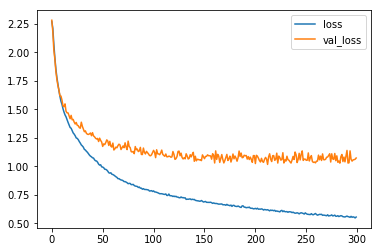

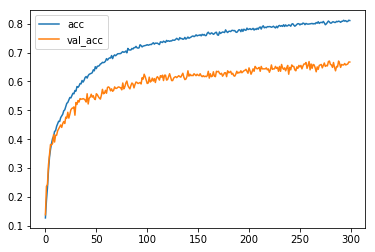

hightest acc is: 0.811873080921
hightest val_acc is: 0.670608108108
hightest val_acc epoch is: 279


In [251]:
 
plt.plot(r_sent_LSTM.history['loss'], label = 'loss')
plt.plot(r_sent_LSTM.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()
plt.plot(r_sent_LSTM.history['acc'], label = 'acc')
plt.plot(r_sent_LSTM.history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()
print('hightest acc is:', np.max(r_sent_LSTM.history['acc']))
print('hightest val_acc is:', np.max(r_sent_LSTM.history['val_acc']))
print('hightest val_acc epoch is:', np.argmax(r_sent_LSTM.history['val_acc']))

In [252]:
predictions_raw_sent_LSTM = [model_sent_LSTM.predict(np.expand_dims(feature, axis=0)) for feature in sequences_test]
#print('prediction_raw are :', predictions_raw)
predictions_sent_LSTM = [np.argmax(percentage) for percentage in predictions_raw_sent_LSTM] 

test_accuracy_sent_LSTM = 100*np.sum(np.array(predictions_sent_LSTM) == np.argmax(authors_test, axis=1))/len(predictions_sent_LSTM)
print('Sent_LSTM Test accuracy: %.4f%%' % test_accuracy_sent_LSTM)
print('F1_Sent_LSTM score is: ',f1_score(np.array(predictions_sent_LSTM), np.argmax(authors_test, axis=1),average='weighted'))

Sent_LSTM Test accuracy: 69.4215%
F1_Sent_LSTM score is:  0.698751496983


In [81]:
#GRU model
model_sent_GRU = Sequential()
#model.add(GRU(32,kernel_regularizer = regularizers.l2(0.01), return_sequences = True))
#for i in range (hidden_size):
    #model.add(GRU(64, return_sequences = True))
model_sent_GRU.add(LSTM(10, input_shape = (10,50)))
model_sent_GRU.add(Dense(10, activation = 'softmax'))
model_sent_GRU.compile(loss = 'categorical_crossentropy', optimizer = optimizer_, metrics = ['accuracy'])
r_sent_GRU = model_sent_GRU.fit(sequences_train, authors_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
             validation_data=(sequences_val, authors_val), shuffle = True)

Train on 4885 samples, validate on 592 samples
Epoch 1/300
4885/4885 [==============================] - 1s - loss: 2.1766 - acc: 0.1760 - val_loss: 2.0321 - val_acc: 0.2720
Epoch 2/300
4885/4885 [==============================] - 0s - loss: 1.8768 - acc: 0.3202 - val_loss: 1.7811 - val_acc: 0.3378
Epoch 3/300
4885/4885 [==============================] - 0s - loss: 1.6434 - acc: 0.4023 - val_loss: 1.6645 - val_acc: 0.4054
Epoch 4/300
4885/4885 [==============================] - 0s - loss: 1.5182 - acc: 0.4549 - val_loss: 1.5686 - val_acc: 0.4324
Epoch 5/300
4885/4885 [==============================] - 0s - loss: 1.4104 - acc: 0.5071 - val_loss: 1.5103 - val_acc: 0.4831
Epoch 6/300
4885/4885 [==============================] - 0s - loss: 1.3552 - acc: 0.5290 - val_loss: 1.4931 - val_acc: 0.4949
Epoch 7/300
4885/4885 [==============================] - 0s - loss: 1.2972 - acc: 0.5476 - val_loss: 1.4306 - val_acc: 0.5000
Epoch 8/300
4885/4885 [==============================] - 0s - loss: 1.2

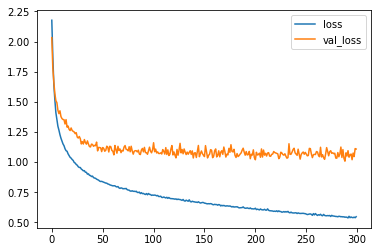

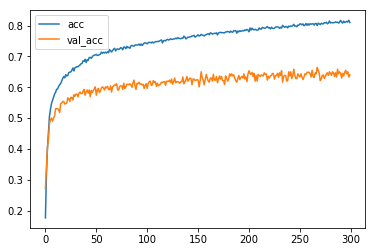

GRU hightest acc is: 0.817604912999
GRU hightest val_acc is: 0.663851351351
GRU hightest val_acc epoch is: 267


In [82]:
plt.plot(r_sent_GRU.history['loss'], label = 'loss')
plt.plot(r_sent_GRU.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()
plt.plot(r_sent_GRU.history['acc'], label = 'acc')
plt.plot(r_sent_GRU.history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()
print('GRU hightest acc is:', np.max(r_sent_GRU.history['acc']))
print('GRU hightest val_acc is:', np.max(r_sent_GRU.history['val_acc']))
print('GRU hightest val_acc epoch is:', np.argmax(r_sent_GRU.history['val_acc']))

In [83]:
predictions_raw_sent_GRU = [model_sent_GRU.predict(np.expand_dims(feature, axis=0)) for feature in sequences_test]
#print('prediction_raw are :', predictions_raw)
predictions_sent_GRU = [np.argmax(percentage) for percentage in predictions_raw_sent_GRU] 

test_accuracy_sent_GRU = 100*np.sum(np.array(predictions_sent_GRU) == np.argmax(authors_test, axis=1))/len(predictions_sent_GRU)
print('Sent_GRU Test accuracy: %.4f%%' % test_accuracy_sent_GRU)
print('F1_Sent_GRU score is: ',f1_score(np.array(predictions_sent_GRU), np.argmax(authors_test, axis=1),average='weighted'))

Sent_GRU Test accuracy: 71.9008%
F1_Sent_GRU score is:  0.727132065975


In [133]:
#CNN model
model_sent_CNN = Sequential()
model_sent_CNN.add(Conv1D(128,2, activation = 'relu', input_shape = (10,50)))
model_sent_CNN.add(MaxPooling1D(2))
#model_sent_CNN.add(Conv1D(128,2, activation = 'relu'))
#model_sent_CNN.add(MaxPooling1D(2))
model_sent_CNN.add(Conv1D(128,2, activation = 'relu'))
model_sent_CNN.add(GlobalMaxPooling1D())
model_sent_CNN.add(Dense(128, activation = 'relu'))
model_sent_CNN.add(Dense(10, activation = 'softmax'))
model_sent_CNN.compile(loss = 'categorical_crossentropy', optimizer = optimizer_, metrics = ['accuracy'])
r_sent_CNN = model_sent_CNN.fit(sequences_train, authors_train, batch_size = BATCH_SIZE, epochs = 10,
             callbacks = [earlyStopping], validation_data=(sequences_val, authors_val), shuffle = True)

Train on 4885 samples, validate on 592 samples
Epoch 1/10
4885/4885 [==============================] - 2s - loss: 2.0869 - acc: 0.2227 - val_loss: 1.8027 - val_acc: 0.3446
Epoch 2/10
4885/4885 [==============================] - 0s - loss: 1.6093 - acc: 0.3945 - val_loss: 1.6650 - val_acc: 0.3750
Epoch 3/10
4885/4885 [==============================] - 0s - loss: 1.4509 - acc: 0.4604 - val_loss: 1.4883 - val_acc: 0.4409
Epoch 4/10
4885/4885 [==============================] - 0s - loss: 1.3195 - acc: 0.5064 - val_loss: 1.4384 - val_acc: 0.4527
Epoch 5/10
4885/4885 [==============================] - 0s - loss: 1.2413 - acc: 0.5443 - val_loss: 1.4781 - val_acc: 0.4628
Epoch 6/10
4885/4885 [==============================] - 0s - loss: 1.1375 - acc: 0.5914 - val_loss: 1.5165 - val_acc: 0.4882
Epoch 7/10
4885/4885 [==============================] - 0s - loss: 1.0770 - acc: 0.6025 - val_loss: 1.3704 - val_acc: 0.5000
Epoch 8/10
4885/4885 [==============================] - 0s - loss: 0.9936 - ac

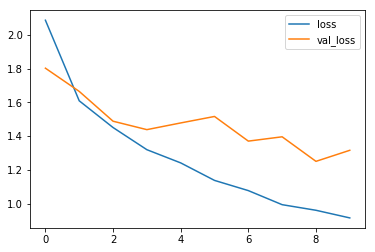

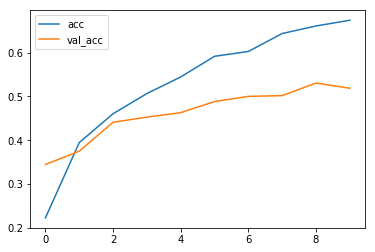

CNN hightest acc is: 0.673694984653
CNN hightest val_acc is: 0.530405405405
CNN hightest val_acc epoch is: 8


In [134]:
plt.plot(r_sent_CNN.history['loss'], label = 'loss')
plt.plot(r_sent_CNN.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()
plt.plot(r_sent_CNN.history['acc'], label = 'acc')
plt.plot(r_sent_CNN.history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()
#print('CNN hightest acc is:', np.max(r_sent_CNN.history['acc']))
#print('CNN hightest val_acc is:', np.max(r_sent_CNN.history['val_acc']))
#print('CNN hightest val_acc epoch is:', np.argmax(r_sent_CNN.history['val_acc']))

In [135]:
predictions_raw_sent_CNN = [model_sent_CNN.predict(np.expand_dims(feature, axis=0)) for feature in sequences_test]
predictions_sent_CNN = [np.argmax(percentage) for percentage in predictions_raw_sent_CNN] 
test_accuracy_sent_CNN = 100*np.sum(np.array(predictions_sent_CNN) == np.argmax(authors_test, axis=1))/len(predictions_sent_CNN)
print('sent_CNN Test accuracy: %.4f%%' % test_accuracy_sent_CNN)
print('F1_sent_CNN score is: ',f1_score(np.array(predictions_sent_CNN), np.argmax(authors_test, axis=1),average='weighted'))

sent_CNN Test accuracy: 55.3719%
F1_sent_CNN score is:  0.560002431526


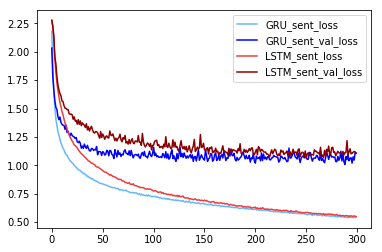

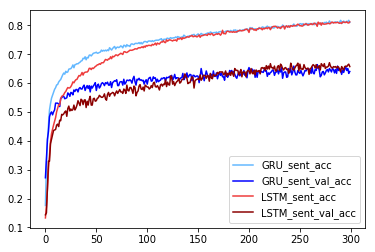

In [138]:
plt.plot(r_sent_GRU.history['loss'], label = 'GRU_sent_loss', color = '#63B8FF')
plt.plot(r_sent_GRU.history['val_loss'], label = 'GRU_sent_val_loss',color = '#0000FF')
plt.plot(r_sent_LSTM.history['loss'], label = 'LSTM_sent_loss', color = '#EE3B3B')
plt.plot(r_sent_LSTM.history['val_loss'], label = 'LSTM_sent_val_loss',color = '#8B0000')
plt.legend()
plt.show()
plt.plot(r_sent_GRU.history['acc'], label = 'GRU_sent_acc', color = '#63B8FF')
plt.plot(r_sent_GRU.history['val_acc'], label = 'GRU_sent_val_acc',color = '#0000FF')
plt.plot(r_sent_LSTM.history['acc'], label = 'LSTM_sent_acc', color = '#EE3B3B')
plt.plot(r_sent_LSTM.history['val_acc'], label = 'LSTM_sent_val_acc',color = '#8B0000')
plt.legend()
plt.show()


**Section three:**---------------------------------------------------------------------------------

**Feature Representation 3:** The linguistic features of the authors are represented by the 'bag-of-words', 'n_grams', 'TF_IDF', and their combinations

In [253]:
#define hyperparameters as constants
MAX_TEXT_SIZE = 200
MAX_VOCABULARY_SIZE = 50000

# read data from csv file
dataset = pd.read_csv("data_files/data.csv", encoding = 'ISO-8859-1')
# map the author names to integers
dataset['authors'] = dataset['authors'].map({'Charles Dickens': 0, 'Mark Twain': 1, 'F. Scott Fitzgerald': 2, 
                                  'Robert Louis Stevenson': 3, 'Henry James': 4, 'Ouida' : 5, 'Jack London': 6,
                                          'Joseph Conrad': 7, 'Jane Austen': 8, 'Herman Melville': 9})
author_names = dataset['authors'].values

#read the text books and text segments from files and write them in the list named 'texts'
book_files = dataset['file_name'].values
texts = []
authors = []
count_train = 0
count_val = 0

for i in range(len(book_files)):
    
    f = codecs.open("data_files/books/" + book_files[i], encoding='utf-8')
    text = ""
    for line in f:        
        text += str(line)
    f.close()
    #divide the book to paragraphs
    text_sentences = text.split("\r\n\r\n")
    text_sentences = [para.replace("\r\n"," ").replace('“','').replace('”','').replace('-','')
                      .replace('*', '').replace('\ufeff', '') for para in text_sentences]
    text_sentences = [para.strip() for para in text_sentences]
    short_text = []
    #combine short paragraphs to longer ones.
    for t in text_sentences:
        if len(t.split(" ")) < 70:
            short_text.append(t) 
            text_sentences.remove(t)
    ii = 0
    com_text=[]
    while ii < len(short_text):
        if (len(short_text[ii].split(" ")) < 70):
            j = ii+1
            combine = short_text[ii]
            while (j < len(short_text) and len((combine+short_text[j]).split(" ")) < 200):
                combine+=short_text[j]
                j+=1
            com_text.append(combine)     
            ii = j
        else:
            i+=1
    text_sentences += com_text
 
    if i < 10:
        count_train += len(text_sentences)
    if i >= 10 and i < 20:
        count_val += len(text_sentences)

    texts += text_sentences
    authors += [author_names[i]]*len(text_sentences)
    
#print('texts.shape', len(texts))    
#texts = np.asarray(texts)
authors = np.asarray(authors)
# convert labels to categorical input
authors = np_utils.to_categorical(authors, 10)
authors_train = authors[:count_train]
authors_val = authors[count_train : count_train + count_val]
authors_test = authors[count_train + count_val :]



In [256]:
texts_train = texts[:count_train]
texts_val = texts[count_train : count_train + count_val]
texts_test = texts[count_train + count_val:]
#save all the vectorizer in a list
feature_vectorizer = []
#save vectorizer names, key is integer from 0 to 4, value is name of each vectorizer
vectorizer_names = {}
word_vectorizer = CountVectorizer(
    strip_accents ='unicode',
    analyzer = 'word',
    max_features = 20000    
    )
feature_vectorizer.append(word_vectorizer)
vectorizer_names[0] = 'word_vectorizer'
tfidf_vectorizer = TfidfVectorizer(
    strip_accents ='unicode',
    analyzer = 'word',
    max_features = 40000    
    )
feature_vectorizer.append(tfidf_vectorizer)
vectorizer_names[1] = 'tfidf_vectorizer'
bigram_char_vectorizer = CountVectorizer(
    strip_accents ='unicode',
    analyzer = 'char',
    ngram_range = (2,3),
        
    )
feature_vectorizer.append(bigram_char_vectorizer)
vectorizer_names[2] = 'bigram_char_vectorizer'
bigram_word_vectorizer = CountVectorizer(
    strip_accents ='unicode',
    analyzer = 'word',
    ngram_range = (2,2),
    max_features = 25000    
    )
feature_vectorizer.append(bigram_word_vectorizer)
vectorizer_names[3] = 'bigram_word_vectorizer'
bigram_tfidf_vectorizer = TfidfVectorizer(
    strip_accents ='unicode',
    analyzer = 'word',
    ngram_range = (2,2),
    max_features = 20000    
    )
feature_vectorizer.append(bigram_tfidf_vectorizer)
vectorizer_names[4] = 'bigram_tfidf_vectorizer'

#print(vectorizer_names.keys(), vectorizer_names.values())
#print(len(feature_vectorizer))

#the features_generator function converts the features to 3 dimensional and save them in the features3D dict
features3D = {}
def features_generator(i):
    vectorizer = feature_vectorizer[i]
    vectorizer.fit(texts)
    train_features = vectorizer.transform(texts_train)
    train_features3D = (train_features.toarray())[:, np.newaxis, :]
    features3D[vectorizer_names[i]+'train'] =  train_features3D
    
    test_features = vectorizer.transform(texts_test)
    test_features3D = test_features.toarray()[:, np.newaxis, :]
    features3D[vectorizer_names[i]+'test'] =  test_features3D
    
    val_features = vectorizer.transform(texts_val)
    val_features3D = val_features.toarray()[:, np.newaxis, :]
    features3D[vectorizer_names[i]+'val'] =  val_features3D
    

In [257]:
#to store the history of various GRU models running on different feature representations 
model_dict = {}

In [258]:
#to store the history of various LSTM models running on different feature representations
model_LSTM_dict = {}

In [260]:
#model_generator takes in the order number of a vectorizer and the algorithm name
# then fit the model with the data represented by the vectorizer[i], save the history in the model_dict 
BATCH_SIZE = 32
EPOCHS = 50
def model_generator(i, model_name):
    optimizer_ = optimizers.Adam(lr = 0.0002)
    model = Sequential()
    model.add(GRU(10, input_shape = (1,features3D[vectorizer_names[i]+'train'].shape[2])))
    model.add(Dense(10, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer_, metrics = ['accuracy'])
    r = model.fit(features3D[vectorizer_names[i]+'train'], authors_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
        validation_data=(features3D[vectorizer_names[i]+'val'], authors_val), shuffle = True)
    if model_name == 'LSTM':
        model_LSTM_dict[i] = r
    else:
        model_dict[i] = r
    plt.plot(r.history['loss'], label = vectorizer_names[i] + 'loss'+'_'+model_name)
    plt.plot(r.history['val_loss'], label = vectorizer_names[i]+'val_loss'+'_'+model_name)
    plt.legend()
    plt.show()
    plt.plot(r.history['acc'], label = vectorizer_names[i] +'acc'+'_'+model_name)
    plt.plot(r.history['val_acc'], label = vectorizer_names[i] +'val_acc'+'_'+model_name)
    plt.legend()
    plt.show()
    print(vectorizer_names[i]+'hightest acc is:', np.max(r.history['acc']))
    print(vectorizer_names[i]+'hightest val_acc is:', np.max(r.history['val_acc']))
    print(vectorizer_names[i]+'hightest val_acc epoch is:', np.argmax(r.history['val_acc']))
    
    predictions_raw = [model.predict(np.expand_dims(feature, axis=0)) for feature in features3D[vectorizer_names[i]+'test']]
    predictions = [np.argmax(percentage) for percentage in predictions_raw] 
    test_accuracy = 100*np.sum(np.array(predictions) == np.argmax(authors_test, axis=1))/len(predictions)
    print(vectorizer_names[i] + 'Test accuracy: %.4f%%' % test_accuracy)
    print(vectorizer_names[i] +'F1 score is: ',f1_score(np.array(predictions), np.argmax(authors_test, axis=1),average='weighted')) 
 

In [262]:
# to run each feature vectorizers one by one, change the number to run different vectorizers
features_generator(0)

Train on 12143 samples, validate on 1310 samples
Epoch 1/50
12143/12143 [==============================] - 23s - loss: 2.0905 - acc: 0.3430 - val_loss: 1.9044 - val_acc: 0.4977
Epoch 2/50
12143/12143 [==============================] - 19s - loss: 1.6844 - acc: 0.6439 - val_loss: 1.5877 - val_acc: 0.6489
Epoch 3/50
12143/12143 [==============================] - 19s - loss: 1.3948 - acc: 0.7310 - val_loss: 1.3367 - val_acc: 0.7237
Epoch 4/50
12143/12143 [==============================] - 19s - loss: 1.1768 - acc: 0.7760 - val_loss: 1.1588 - val_acc: 0.7511
Epoch 5/50
12143/12143 [==============================] - 19s - loss: 1.0160 - acc: 0.8027 - val_loss: 1.0265 - val_acc: 0.7740
Epoch 6/50
12143/12143 [==============================] - 20s - loss: 0.8905 - acc: 0.8239 - val_loss: 0.9234 - val_acc: 0.7885
Epoch 7/50
12143/12143 [==============================] - 20s - loss: 0.7907 - acc: 0.8400 - val_loss: 0.8415 - val_acc: 0.8008
Epoch 8/50
12143/12143 [==============================]

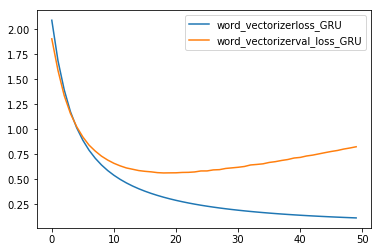

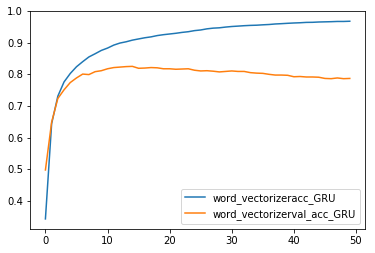

word_vectorizerhightest acc is: 0.967800378819
word_vectorizerhightest val_acc is: 0.825190839786
word_vectorizerhightest val_acc epoch is: 14
word_vectorizerTest accuracy: 83.2031%
word_vectorizerF1 score is:  0.832550423987


In [263]:
model_generator(0, 'GRU')

Train on 12143 samples, validate on 1310 samples
Epoch 1/50
12143/12143 [==============================] - 24s - loss: 2.0788 - acc: 0.3442 - val_loss: 1.8741 - val_acc: 0.4977
Epoch 2/50
12143/12143 [==============================] - 20s - loss: 1.6487 - acc: 0.6485 - val_loss: 1.5571 - val_acc: 0.6366.648
Epoch 3/50
12143/12143 [==============================] - 20s - loss: 1.3751 - acc: 0.7268 - val_loss: 1.3466 - val_acc: 0.6885
Epoch 4/50
12143/12143 [==============================] - 20s - loss: 1.1746 - acc: 0.7768 - val_loss: 1.1709 - val_acc: 0.7351
Epoch 5/50
12143/12143 [==============================] - 20s - loss: 1.0102 - acc: 0.8047 - val_loss: 1.0294 - val_acc: 0.7664
Epoch 6/50
12143/12143 [==============================] - 20s - loss: 0.8821 - acc: 0.8285 - val_loss: 0.9224 - val_acc: 0.7924
Epoch 7/50
12143/12143 [==============================] - 20s - loss: 0.7822 - acc: 0.8457 - val_loss: 0.8488 - val_acc: 0.7977
Epoch 8/50
12143/12143 [===========================

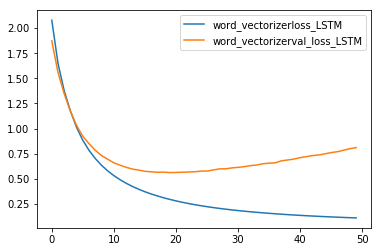

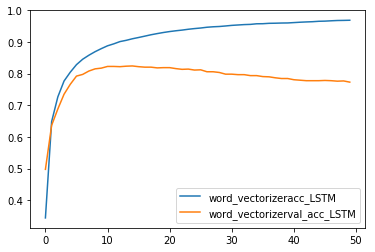

word_vectorizerhightest acc is: 0.968870954459
word_vectorizerhightest val_acc is: 0.824427480279
word_vectorizerhightest val_acc epoch is: 14
word_vectorizerTest accuracy: 82.8125%
word_vectorizerF1 score is:  0.825476888433


In [264]:
model_generator(0, 'LSTM')

Train on 12143 samples, validate on 1310 samples
Epoch 1/50
12143/12143 [==============================] - 41s - loss: 2.2683 - acc: 0.2020 - val_loss: 2.2504 - val_acc: 0.1557
Epoch 2/50
12143/12143 [==============================] - 35s - loss: 2.1751 - acc: 0.2033 - val_loss: 2.1842 - val_acc: 0.1557
Epoch 3/50
12143/12143 [==============================] - 35s - loss: 2.0679 - acc: 0.2077 - val_loss: 2.0981 - val_acc: 0.1573
Epoch 4/50
12143/12143 [==============================] - 36s - loss: 1.9378 - acc: 0.2539 - val_loss: 1.9712 - val_acc: 0.2038
Epoch 5/50
12143/12143 [==============================] - 36s - loss: 1.7720 - acc: 0.4435 - val_loss: 1.8094 - val_acc: 0.4267
Epoch 6/50
12143/12143 [==============================] - 36s - loss: 1.5876 - acc: 0.6441 - val_loss: 1.6429 - val_acc: 0.5954
Epoch 7/50
12143/12143 [==============================] - 35s - loss: 1.4083 - acc: 0.7506 - val_loss: 1.4894 - val_acc: 0.6664
Epoch 8/50
12143/12143 [==============================]

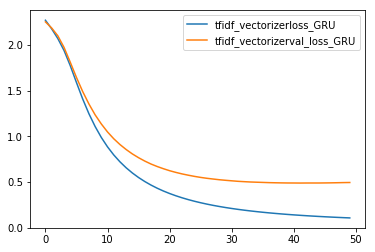

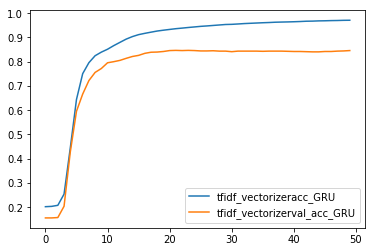

tfidf_vectorizerhightest acc is: 0.970847401795
tfidf_vectorizerhightest val_acc is: 0.846564885496
tfidf_vectorizerhightest val_acc epoch is: 21
tfidf_vectorizerTest accuracy: 87.1094%
tfidf_vectorizerF1 score is:  0.866612120466
Train on 12143 samples, validate on 1310 samples
Epoch 1/50
12143/12143 [==============================] - 39s - loss: 2.2660 - acc: 0.2107 - val_loss: 2.2399 - val_acc: 0.1557
Epoch 2/50
12143/12143 [==============================] - 35s - loss: 2.1643 - acc: 0.2113 - val_loss: 2.1586 - val_acc: 0.1626
Epoch 3/50
12143/12143 [==============================] - 35s - loss: 2.0432 - acc: 0.2509 - val_loss: 2.0546 - val_acc: 0.2214
Epoch 4/50
12143/12143 [==============================] - 35s - loss: 1.8996 - acc: 0.3771 - val_loss: 1.9158 - val_acc: 0.3183
Epoch 5/50
12143/12143 [==============================] - 36s - loss: 1.7314 - acc: 0.5160 - val_loss: 1.7575 - val_acc: 0.4267
Epoch 6/50
12143/12143 [==============================] - 36s - loss: 1.5557 - a

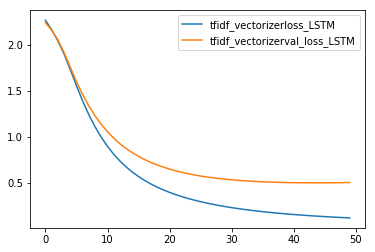

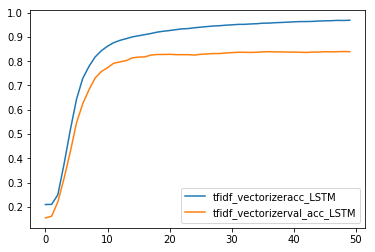

tfidf_vectorizerhightest acc is: 0.968212138686
tfidf_vectorizerhightest val_acc is: 0.839694656489
tfidf_vectorizerhightest val_acc epoch is: 48
tfidf_vectorizerTest accuracy: 85.1562%
tfidf_vectorizerF1 score is:  0.848538937679
Train on 12143 samples, validate on 1310 samples
Epoch 1/50
12143/12143 [==============================] - 18s - loss: 1.8204 - acc: 0.4372 - val_loss: 1.5636 - val_acc: 0.5794
Epoch 2/50
12143/12143 [==============================] - 14s - loss: 1.3477 - acc: 0.7128 - val_loss: 1.2356 - val_acc: 0.7298
Epoch 3/50
12143/12143 [==============================] - 14s - loss: 1.0841 - acc: 0.8008 - val_loss: 1.0573 - val_acc: 0.7718
Epoch 4/50
12143/12143 [==============================] - 14s - loss: 0.9003 - acc: 0.8431 - val_loss: 0.9280 - val_acc: 0.7908
Epoch 5/50
12143/12143 [==============================] - 14s - loss: 0.7572 - acc: 0.8688 - val_loss: 0.8196 - val_acc: 0.8084
Epoch 6/50
12143/12143 [==============================] - 14s - loss: 0.6454 - a

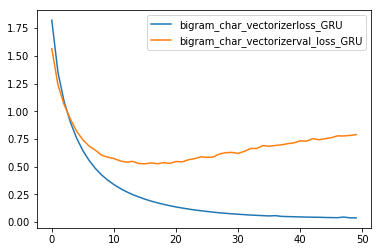

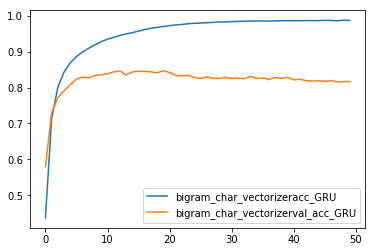

bigram_char_vectorizerhightest acc is: 0.987235444289
bigram_char_vectorizerhightest val_acc is: 0.846564885496
bigram_char_vectorizerhightest val_acc epoch is: 19
bigram_char_vectorizerTest accuracy: 83.2031%
bigram_char_vectorizerF1 score is:  0.826773067196
Train on 12143 samples, validate on 1310 samples
Epoch 1/50
12143/12143 [==============================] - 18s - loss: 1.7678 - acc: 0.4911 - val_loss: 1.4613 - val_acc: 0.6374
Epoch 2/50
12143/12143 [==============================] - 14s - loss: 1.2769 - acc: 0.7502 - val_loss: 1.1746 - val_acc: 0.7183
Epoch 3/50
12143/12143 [==============================] - 15s - loss: 1.0270 - acc: 0.8213 - val_loss: 1.0059 - val_acc: 0.7702
Epoch 4/50
12143/12143 [==============================] - 15s - loss: 0.8477 - acc: 0.8558 - val_loss: 0.8681 - val_acc: 0.7962
Epoch 5/50
12143/12143 [==============================] - 15s - loss: 0.7090 - acc: 0.8779 - val_loss: 0.7746 - val_acc: 0.8069
Epoch 6/50
12143/12143 [==========================

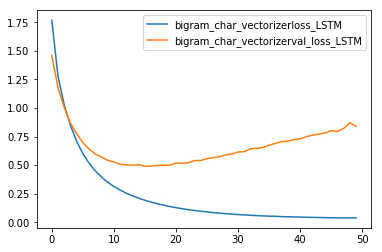

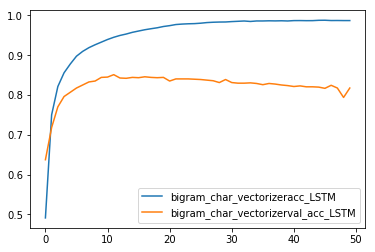

bigram_char_vectorizerhightest acc is: 0.987894260068
bigram_char_vectorizerhightest val_acc is: 0.851145038259
bigram_char_vectorizerhightest val_acc epoch is: 11
bigram_char_vectorizerTest accuracy: 83.2031%
bigram_char_vectorizerF1 score is:  0.830956819397
Train on 12143 samples, validate on 1310 samples
Epoch 1/50
12143/12143 [==============================] - 28s - loss: 2.1831 - acc: 0.2917 - val_loss: 2.0585 - val_acc: 0.3405
Epoch 2/50
12143/12143 [==============================] - 26s - loss: 1.8413 - acc: 0.5399 - val_loss: 1.7661 - val_acc: 0.5489
Epoch 3/50
12143/12143 [==============================] - 30s - loss: 1.5389 - acc: 0.6862 - val_loss: 1.5500 - val_acc: 0.6076
Epoch 4/50
12143/12143 [==============================] - 25s - loss: 1.3144 - acc: 0.7409 - val_loss: 1.3885 - val_acc: 0.6511
Epoch 5/50
12143/12143 [==============================] - 25s - loss: 1.1451 - acc: 0.7769 - val_loss: 1.2684 - val_acc: 0.6809
Epoch 6/50
12143/12143 [==========================

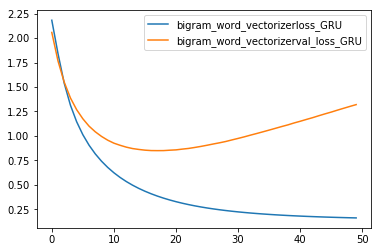

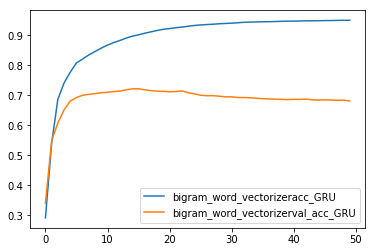

bigram_word_vectorizerhightest acc is: 0.949682944911
bigram_word_vectorizerhightest val_acc is: 0.721374045984
bigram_word_vectorizerhightest val_acc epoch is: 14
bigram_word_vectorizerTest accuracy: 75.0000%
bigram_word_vectorizerF1 score is:  0.7462944481
Train on 12143 samples, validate on 1310 samples
Epoch 1/50
12143/12143 [==============================] - 27s - loss: 2.1778 - acc: 0.2877 - val_loss: 2.0562 - val_acc: 0.3427
Epoch 2/50
12143/12143 [==============================] - 23s - loss: 1.8385 - acc: 0.5386 - val_loss: 1.7600 - val_acc: 0.5252
Epoch 3/50
12143/12143 [==============================] - 23s - loss: 1.5434 - acc: 0.6619 - val_loss: 1.5524 - val_acc: 0.6000
Epoch 4/50
12143/12143 [==============================] - 24s - loss: 1.3310 - acc: 0.7276 - val_loss: 1.4052 - val_acc: 0.6397
Epoch 5/50
12143/12143 [==============================] - 24s - loss: 1.1679 - acc: 0.7745 - val_loss: 1.2914 - val_acc: 0.6649
Epoch 6/50
12143/12143 [============================

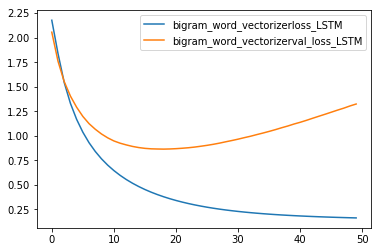

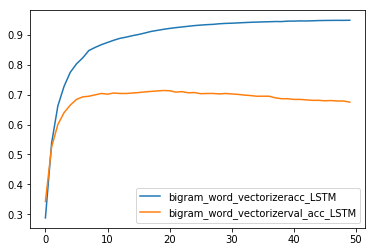

bigram_word_vectorizerhightest acc is: 0.948694721243
bigram_word_vectorizerhightest val_acc is: 0.71374045756
bigram_word_vectorizerhightest val_acc epoch is: 19
bigram_word_vectorizerTest accuracy: 72.6562%
bigram_word_vectorizerF1 score is:  0.722655732841
Train on 12143 samples, validate on 1310 samples
Epoch 1/50
12143/12143 [==============================] - 22s - loss: 2.2773 - acc: 0.2173 - val_loss: 2.2628 - val_acc: 0.1595
Epoch 2/50
12143/12143 [==============================] - 18s - loss: 2.2072 - acc: 0.2070 - val_loss: 2.2138 - val_acc: 0.1557
Epoch 3/50
12143/12143 [==============================] - 18s - loss: 2.1269 - acc: 0.2028 - val_loss: 2.1600 - val_acc: 0.1557
Epoch 4/50
12143/12143 [==============================] - 19s - loss: 2.0414 - acc: 0.2157 - val_loss: 2.0920 - val_acc: 0.1695
Epoch 5/50
12143/12143 [==============================] - 18s - loss: 1.9435 - acc: 0.2696 - val_loss: 2.0044 - val_acc: 0.2344
Epoch 6/50
12143/12143 [===========================

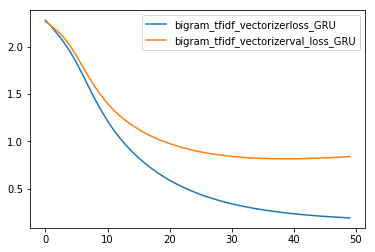

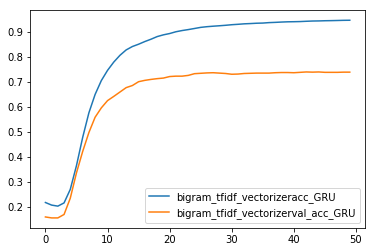

bigram_tfidf_vectorizerhightest acc is: 0.9455653463
bigram_tfidf_vectorizerhightest val_acc is: 0.738931297892
bigram_tfidf_vectorizerhightest val_acc epoch is: 42
bigram_tfidf_vectorizerTest accuracy: 78.5156%
bigram_tfidf_vectorizerF1 score is:  0.784901971017
Train on 12143 samples, validate on 1310 samples
Epoch 1/50
12143/12143 [==============================] - 22s - loss: 2.2773 - acc: 0.2071 - val_loss: 2.2660 - val_acc: 0.1557
Epoch 2/50
12143/12143 [==============================] - 18s - loss: 2.2094 - acc: 0.2033 - val_loss: 2.2211 - val_acc: 0.1557
Epoch 3/50
12143/12143 [==============================] - 18s - loss: 2.1294 - acc: 0.2038 - val_loss: 2.1679 - val_acc: 0.1580
Epoch 4/50
12143/12143 [==============================] - 18s - loss: 2.0413 - acc: 0.2183 - val_loss: 2.1003 - val_acc: 0.1702
Epoch 5/50
12143/12143 [==============================] - 18s - loss: 1.9397 - acc: 0.2762 - val_loss: 2.0141 - val_acc: 0.2321
Epoch 6/50
12143/12143 [=======================

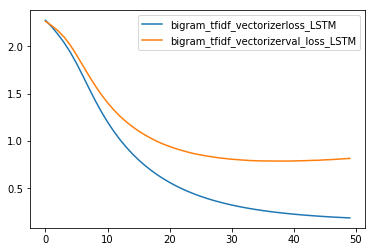

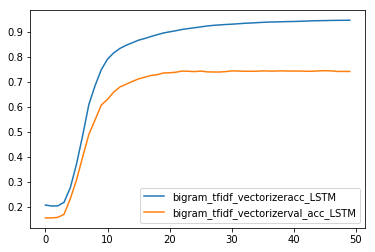

bigram_tfidf_vectorizerhightest acc is: 0.945894754184
bigram_tfidf_vectorizerhightest val_acc is: 0.744274809251
bigram_tfidf_vectorizerhightest val_acc epoch is: 45
bigram_tfidf_vectorizerTest accuracy: 79.6875%
bigram_tfidf_vectorizerF1 score is:  0.797327102678


In [265]:
# to run the remainder feature vectorizers in a loop, change the numbers to run different range
for i in range(1,5):
    features_generator(i)
    model_generator(i,'GRU')
    model_generator(i,'LSTM')

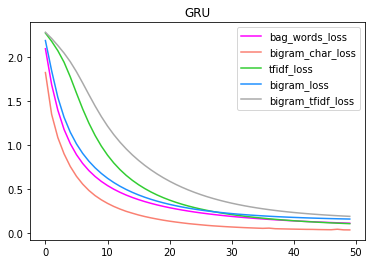

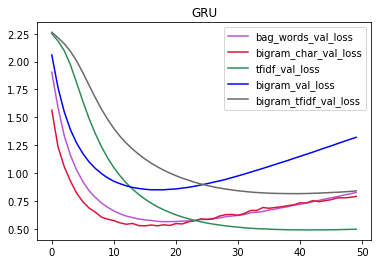

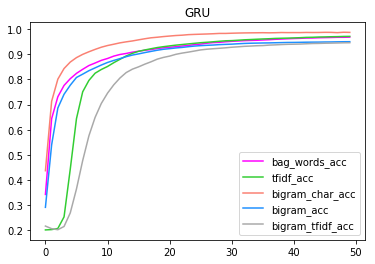

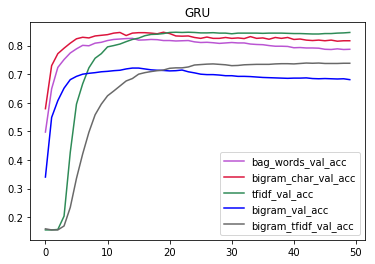

In [266]:
#combine all the plots
plt.title('GRU')
plt.plot(model_dict[0].history['loss'], label = 'bag_words' + '_loss', color = '#FF00FF')
plt.plot(model_dict[2].history['loss'], label = 'bigram_char' + '_loss', color = '#FA8072')
plt.plot(model_dict[1].history['loss'], label = 'tfidf' + '_loss', color = '#32CD32')
plt.plot(model_dict[3].history['loss'], label = 'bigram' + '_loss', color = '#1E90FF')
plt.plot(model_dict[4].history['loss'], label = 'bigram_tfidf' + '_loss', color = '#A9A9A9')
plt.legend()
plt.show()
plt.title('GRU')
plt.plot(model_dict[0].history['val_loss'], label = 'bag_words'+'_val_loss',color = '#BA55D3')
plt.plot(model_dict[2].history['val_loss'], label = 'bigram_char'+'_val_loss',color = '#DC143C')
plt.plot(model_dict[1].history['val_loss'], label = 'tfidf'+'_val_loss',color = '#2E8B57')
plt.plot(model_dict[3].history['val_loss'], label = 'bigram'+'_val_loss',color = '#0000FF')
plt.plot(model_dict[4].history['val_loss'], label = 'bigram_tfidf'+'_val_loss',color = '#696969')
plt.legend()
plt.show()
plt.title('GRU')
plt.plot(model_dict[0].history['acc'], label = 'bag_words' + '_acc', color = '#FF00FF')
plt.plot(model_dict[1].history['acc'], label = 'tfidf' + '_acc', color = '#32CD32')
plt.plot(model_dict[2].history['acc'], label = 'bigram_char' + '_acc', color = '#FA8072')
plt.plot(model_dict[3].history['acc'], label = 'bigram' + '_acc', color = '#1E90FF')
plt.plot(model_dict[4].history['acc'], label = 'bigram_tfidf' + '_acc', color = '#A9A9A9')
plt.legend()
plt.show()
plt.title('GRU')
plt.plot(model_dict[0].history['val_acc'], label = 'bag_words'+'_val_acc',color = '#BA55D3')
plt.plot(model_dict[2].history['val_acc'], label = 'bigram_char'+'_val_acc',color = '#DC143C')
plt.plot(model_dict[1].history['val_acc'], label = 'tfidf'+'_val_acc',color = '#2E8B57')
plt.plot(model_dict[3].history['val_acc'], label = 'bigram'+'_val_acc',color = '#0000FF')
plt.plot(model_dict[4].history['val_acc'], label = 'bigram_tfidf'+'_val_acc',color = '#696969')
plt.legend()
plt.show()

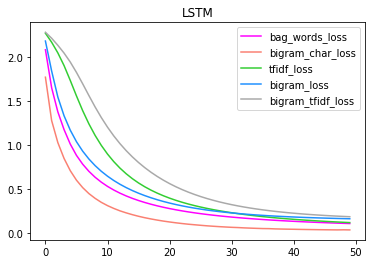

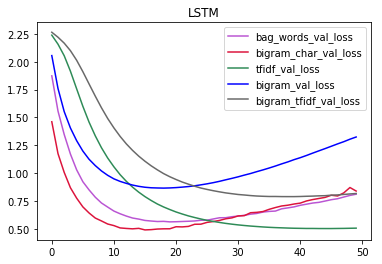

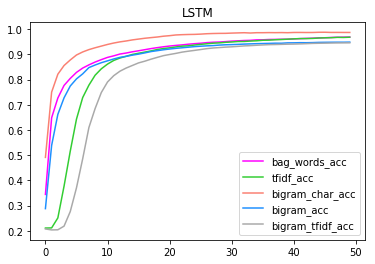

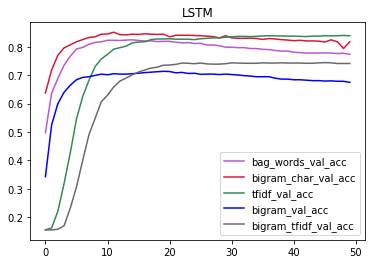

In [267]:
#combine all the plots
plt.title('LSTM')
plt.plot(model_LSTM_dict[0].history['loss'], label = 'bag_words' + '_loss', color = '#FF00FF')
plt.plot(model_LSTM_dict[2].history['loss'], label = 'bigram_char' + '_loss', color = '#FA8072')
plt.plot(model_LSTM_dict[1].history['loss'], label = 'tfidf' + '_loss', color = '#32CD32')
plt.plot(model_LSTM_dict[3].history['loss'], label = 'bigram' + '_loss', color = '#1E90FF')
plt.plot(model_LSTM_dict[4].history['loss'], label = 'bigram_tfidf' + '_loss', color = '#A9A9A9')
plt.legend()
plt.show()
plt.title('LSTM')
plt.plot(model_LSTM_dict[0].history['val_loss'], label = 'bag_words'+'_val_loss',color = '#BA55D3')
plt.plot(model_LSTM_dict[2].history['val_loss'], label = 'bigram_char'+'_val_loss',color = '#DC143C')
plt.plot(model_LSTM_dict[1].history['val_loss'], label = 'tfidf'+'_val_loss',color = '#2E8B57')
plt.plot(model_LSTM_dict[3].history['val_loss'], label = 'bigram'+'_val_loss',color = '#0000FF')
plt.plot(model_LSTM_dict[4].history['val_loss'], label = 'bigram_tfidf'+'_val_loss',color = '#696969')
plt.legend()
plt.show()
plt.title('LSTM')
plt.plot(model_LSTM_dict[0].history['acc'], label = 'bag_words' + '_acc', color = '#FF00FF')
plt.plot(model_LSTM_dict[1].history['acc'], label = 'tfidf' + '_acc', color = '#32CD32')
plt.plot(model_LSTM_dict[2].history['acc'], label = 'bigram_char' + '_acc', color = '#FA8072')
plt.plot(model_LSTM_dict[3].history['acc'], label = 'bigram' + '_acc', color = '#1E90FF')
plt.plot(model_LSTM_dict[4].history['acc'], label = 'bigram_tfidf' + '_acc', color = '#A9A9A9')
plt.legend()
plt.show()
plt.title('LSTM')
plt.plot(model_LSTM_dict[0].history['val_acc'], label = 'bag_words'+'_val_acc',color = '#BA55D3')
plt.plot(model_LSTM_dict[2].history['val_acc'], label = 'bigram_char'+'_val_acc',color = '#DC143C')
plt.plot(model_LSTM_dict[1].history['val_acc'], label = 'tfidf'+'_val_acc',color = '#2E8B57')
plt.plot(model_LSTM_dict[3].history['val_acc'], label = 'bigram'+'_val_acc',color = '#0000FF')
plt.plot(model_LSTM_dict[4].history['val_acc'], label = 'bigram_tfidf'+'_val_acc',color = '#696969')
plt.legend()
plt.show()